In [14]:
vulnerable_sc_path = './smartbugs-curated/dataset'
arithmetic_sc = vulnerable_sc_path + '/arithmetic/'

contracts = './smartbugs-wild/contracts/'

# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
%pip install py-solc-x
%pip install solidity_parser

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from solidity_parser import parser
import os

In [3]:
def get_nodes(ast, nodes, current_key):
  if isinstance(ast, list):
    for item in ast:
      get_nodes(item, nodes, current_key)
  elif isinstance(ast, dict):
    for key in ast.keys():
      get_nodes(ast[key], nodes, key)
  else:
    node = [current_key, ast]
    if node not in nodes: # Maybe it's better to append all of them? Occurrence affects the model?
      nodes.append(node)

In [5]:
def get_ast_arithmetic():
  asts = []

  for dirpath, dirnames, filenames in os.walk(arithmetic_sc):
    for filename in filenames:
      if filename.endswith('.sol'):
        with open(arithmetic_sc + filename, 'r') as file:
          source_code = file.read()
          ast = parser.parse(source_code)
          asts.append(ast)

  return asts      

asts_arithmetic = get_ast_arithmetic()

In [6]:
print("There are {} Smart Contracts with Arithmetic Vulnerabilities".format(len(asts_arithmetic)))
print("Example of AST: {}".format(asts_arithmetic[0]))

There are 15 Smart Contracts with Arithmetic Vulnerabilities
Example of AST: {'type': 'SourceUnit', 'children': [{'type': 'PragmaDirective', 'name': 'solidity', 'value': '^0.4.18'}, {'type': 'ContractDefinition', 'name': 'Token', 'baseContracts': [], 'subNodes': [{'type': 'StateVariableDeclaration', 'variables': [{'type': 'VariableDeclaration', 'typeName': {'type': 'Mapping', 'keyType': {'type': 'ElementaryTypeName', 'name': 'address'}, 'valueType': {'type': 'ElementaryTypeName', 'name': 'uint'}}, 'name': 'balances', 'expression': None, 'visibility': 'default', 'isStateVar': True, 'isDeclaredConst': False, 'isIndexed': False}], 'initialValue': None}, {'type': 'StateVariableDeclaration', 'variables': [{'type': 'VariableDeclaration', 'typeName': {'type': 'ElementaryTypeName', 'name': 'uint'}, 'name': 'totalSupply', 'expression': None, 'visibility': 'public', 'isStateVar': True, 'isDeclaredConst': False, 'isIndexed': False}], 'initialValue': None}, {'type': 'FunctionDefinition', 'name': '

In [7]:
def get_common_nodes(nodes_contract, nodes_arithmetic):
  common_nodes = []
  
  for node_arithmetic in nodes_arithmetic:
    nodes = []
    for node in nodes_contract:
      if node in node_arithmetic:
        # print("Node: {} is present in the vulnerable contracts".format(node))
        nodes.append(node)
      else:
        # print("Node: {} is not present in AST2".format(node))
        pass
    common_nodes.append(nodes)
  
  return common_nodes

with open(contracts + '0x0000000000377d181a0ebd08590c6b399b272000.sol', 'r') as file:
  contract = file.read()

# Gives the AST representation of the contract that we are auditing
ast_contract = parser.parse(contract)
nodes_contract = []

# Gives the nodes in a list format instead of a nested JSON with dictionaries and lists (This is useful to compare the nodes to the vulnerable ones)
get_nodes(ast_contract, nodes_contract, None)

nodes_arithmetic = []

for ast in asts_arithmetic:
  nodes = []
  get_nodes(ast, nodes, None)
  nodes_arithmetic.append(nodes)

common_nodes = get_common_nodes(nodes_contract, nodes_arithmetic)

print(len(common_nodes))

percentage_of_common_nodes = []

for i, nodes in enumerate(common_nodes):
  percentage_of_common_nodes.append(len(nodes) / len(nodes_contract)) # nodes_contract or nodes_arithmetic[i]?

print(np.array(percentage_of_common_nodes))
  

15
[0.25388601 0.18134715 0.16062176 0.16062176 0.19170984 0.16062176
 0.24352332 0.17098446 0.16062176 0.15544041 0.15025907 0.24870466
 0.1865285  0.41450777 0.18134715]


In [8]:
# Get all the folders from inside the folder smartbugs-results/results/oyente/icse20

directory_results_oyente = './smartbugs-results/results/oyente/icse20'

contracts_folders_names = [item for item in os.listdir(directory_results_oyente) if os.path.isdir(os.path.join(directory_results_oyente, item))]
print(len(contracts_folders_names))

# Create an array to store whether they are arithmetically vulnerable or not
contracts_vulnerability = {}

import json

for folder_name in contracts_folders_names:
  with open(directory_results_oyente + '/' + folder_name + '/result.json', 'r') as file:
    result = json.load(file)
    is_vulnerable = 0
    for analysis in result['analysis']:
      if 'integer_overflow' in analysis:
        if analysis['integer_overflow'] == True:
          is_vulnerable = 1
          break
      if 'integer_underflow' in analysis:
        if analysis['integer_underflow'] == True:
          is_vulnerable = 1
          break
    contracts_vulnerability[folder_name] = is_vulnerable

print(len(contracts_vulnerability))

47555
47555


In [17]:
for key in sorted(contracts_vulnerability)[:10]:
    print("%s: %s" % (key, contracts_vulnerability[key]))

sorted_contracts_keys = np.array(sorted(contracts_vulnerability))

print(sorted_contracts_keys[:10])
print(len(sorted_contracts_keys))

0x0000000000027f6d87be8ade118d9ee56767d993: 1
0x0000000000085d4780b73119b644ae5ecd22b376: 0
0x00000000000da14c27c155bb7c1ac9bd7519eb3b: 0
0x00000000000fe8503db73c68f1a1874eb9d86883: 0
0x00000000002b13cccec913420a21e4d11b2dcd3c: 0
0x0000000000377d181a0ebd08590c6b399b272000: 0
0x000000000063b99b8036c31e91c64fc89bff9ca7: 0
0x0000000000b3f879cb30fe243b4dfee438691c04: 1
0x0000000000c5fd1aef1a9421626cf804086185e9: 0
0x00000000037790973600b70888431f463bce360d: 0
['0x0000000000027f6d87be8ade118d9ee56767d993'
 '0x0000000000085d4780b73119b644ae5ecd22b376'
 '0x00000000000da14c27c155bb7c1ac9bd7519eb3b'
 '0x00000000000fe8503db73c68f1a1874eb9d86883'
 '0x00000000002b13cccec913420a21e4d11b2dcd3c'
 '0x0000000000377d181a0ebd08590c6b399b272000'
 '0x000000000063b99b8036c31e91c64fc89bff9ca7'
 '0x0000000000b3f879cb30fe243b4dfee438691c04'
 '0x0000000000c5fd1aef1a9421626cf804086185e9'
 '0x00000000037790973600b70888431f463bce360d']
47555


In [125]:
%pip install tqdm

  Using cached https://files.pythonhosted.org/packages/e6/02/a2cff6306177ae6bc73bc0665065de51dfb3b9db7373e122e2735faf0d97/tqdm-4.65.0-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tqdm import tqdm
input_data = np.array([])
for key in tqdm(sorted_contracts_keys):
  with open(contracts + key + '.sol', 'r') as file:
    lines = len(file.readlines())
  
  if lines < 10:
    print("Error with {}".format(key)) # Remove this key from the dictionary contracts_vulnerability and from sorted_contracts_keys
    print("Removing {} from the dictionary".format(key))
    # REMOVE FROM DICTIONARY
    del contracts_vulnerability[key]
  
  try:
    with open(contracts + key + '.sol', 'r') as file:
      contract = file.read()

    # Gives the AST representation of the contract that we are auditing
    ast_contract = parser.parse(contract)
    nodes_contract = []

    # Gives the nodes in a list format instead of a nested JSON with dictionaries and lists (This is useful to compare the nodes to the vulnerable ones)
    get_nodes(ast_contract, nodes_contract, None)

    common_nodes = get_common_nodes(nodes_contract, nodes_arithmetic)

    percentage_of_common_nodes = []

    for i, nodes in enumerate(common_nodes):
      percentage_of_common_nodes.append(len(nodes) / len(nodes_contract)) # nodes_contract or nodes_arithmetic[i]?
      
    if input_data.size == 0:
      input_data = np.array(percentage_of_common_nodes)
    elif input_data.size == 15:
      input_data = np.append([input_data], [percentage_of_common_nodes], axis=0)
    else:
      input_data = np.append(input_data, [percentage_of_common_nodes], axis=0)
  except:
    print("Error with {}".format(key)) # Remove this key from the dictionary contracts_vulnerability and from sorted_contracts_keys
    print("Removing {} from the dictionary".format(key))
    # REMOVE FROM DICTIONARY
    del contracts_vulnerability[key]
      
sorted_contracts_keys = sorted(contracts_vulnerability) # Already with the deleted keys

In [19]:
sorted_output_np = np.array([])

for key in sorted_contracts_keys:
  sorted_output_np = np.append(sorted_output_np, contracts_vulnerability[key])

print(sorted_output_np[:10])
print(sorted_output_np.size)

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
47026


In [32]:
print(sorted_output_np.shape)
print(input_data.shape)
print(len(sorted_contracts_keys))
print(len(contracts_vulnerability))

for i, key in enumerate(sorted_contracts_keys[:5]):
    print("%s: %s" % (key, sorted_output_np[i]))

# We removed 529 contracts from the dataset that were corrupted or that had an error when parsing the AST

(47026,)
(47026, 15)
47026
47026
0x0000000000027f6d87be8ade118d9ee56767d993: 1.0
0x0000000000085d4780b73119b644ae5ecd22b376: 0.0
0x00000000000da14c27c155bb7c1ac9bd7519eb3b: 0.0
0x00000000000fe8503db73c68f1a1874eb9d86883: 0.0
0x00000000002b13cccec913420a21e4d11b2dcd3c: 0.0


In [32]:
import pickle as pkl
import numpy as np

input_data = np.array([])
sorted_output_np = np.array([])
sorted_contracts_keys = np.array([])
contracts_vulnerability = {}

with open('input_data.pkl', 'wb') as file:
  pkl.dump(input_data, file)

with open('output_data.pkl', 'wb') as file:
  pkl.dump(sorted_output_np, file)
  
with open('sorted_contracts_keys.pkl', 'wb') as file:
  pkl.dump(sorted_contracts_keys, file)

with open('contracts_vulnerability.pkl', 'wb') as file:
  pkl.dump(contracts_vulnerability, file)

In [ ]:
# Minimum and maximum input data
print(contracts_vulnerability)
print(np.min(input_data))
print(np.max(input_data))

In [34]:
%pip install scikit-learn

     |████████████████████████████████| 9.1MB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 62.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d9/7d/78b8035bc93c869b9f17261c87aae97a9cdb937f65f0d453c2831aa172fc/scipy-1.10.1-cp39-cp39-macosx_10_9_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, sorted_output_np, test_size=0.2, random_state=42)

# Create the logistic regression model
model_LR = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1.0, 10.0],
}

# Perform grid search with parallel processing
grid_search = GridSearchCV(model_LR, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the testing data using the best model
predictions = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions) * 100
precision = precision_score(y_test, predictions) * 100
recall = recall_score(y_test, predictions) * 100
cross_val_scores = cross_val_score(best_model, input_data, sorted_output_np, cv=5) * 100

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_params)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Cross-validation score: {:.2f}%".format(cross_val_scores.mean()))

Best Hyperparameters: {'C': 1.0}
Accuracy: 79.49%
Precision: 80.00%
Recall: 95.85%
Cross-validation score: 79.55%


In [51]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, sorted_output_np, test_size=0.2, random_state=42)

# Create the decision tree classifier
model_DTC = DecisionTreeClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with parallel processing
grid_search = GridSearchCV(model_DTC, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the testing data using the best model
predictions = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions) * 100
precision = precision_score(y_test, predictions) * 100
recall = recall_score(y_test, predictions) * 100
cross_val_scores = cross_val_score(best_model, input_data, sorted_output_np, cv=5) * 100

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_params)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Cross-validation score: {:.2f}%".format(cross_val_scores.mean()))

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Accuracy: 83.16%
Precision: 88.87%
Recall: 87.92%
Cross-validation score: 83.19%


In [52]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, sorted_output_np, test_size=0.2, random_state=42)

# Create the random forest classifier
model_RFC = RandomForestClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with parallel processing
grid_search = GridSearchCV(model_RFC, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the testing data using the best model
predictions = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions) * 100
precision = precision_score(y_test, predictions) * 100
recall = recall_score(y_test, predictions) * 100
cross_val_scores = cross_val_score(best_model, input_data, sorted_output_np, cv=5) * 100

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_params)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Cross-validation score: {:.2f}%".format(cross_val_scores.mean()))

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 87.41%
Precision: 88.16%
Recall: 95.58%
Cross-validation score: 87.26%


In [53]:
from sklearn.svm import SVC

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, sorted_output_np, test_size=0.2, random_state=42)

# Create the Support Vector Classifier
model_SVC = SVC()

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform grid search with parallel processing
grid_search = GridSearchCV(model_SVC, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the testing data using the best model
predictions = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions) * 100
precision = precision_score(y_test, predictions) * 100
recall = recall_score(y_test, predictions) * 100
cross_val_scores = cross_val_score(best_model, input_data, sorted_output_np, cv=5) * 100

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_params)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Cross-validation score: {:.2f}%".format(cross_val_scores.mean()))

Best Hyperparameters: {'C': 10.0, 'kernel': 'rbf'}
Accuracy: 80.15%
Precision: 80.35%
Recall: 96.34%
Cross-validation score: 80.27%


In [54]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, sorted_output_np, test_size=0.2, random_state=42)

# Create the Gradient Boosting Classifier
model_GBC = GradientBoostingClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search with parallel processing
grid_search = GridSearchCV(model_GBC, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the testing data using the best model
predictions = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions) * 100
precision = precision_score(y_test, predictions) * 100
recall = recall_score(y_test, predictions) * 100
cross_val_scores = cross_val_score(best_model, input_data, sorted_output_np, cv=5) * 100

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_params)
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Cross-validation score: {:.2f}%".format(cross_val_scores.mean()))

Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 300}
Accuracy: 82.22%
Precision: 82.21%
Recall: 96.52%
Cross-validation score: 82.36%


In [56]:
arithmetic = {}

for folder_name in contracts_folders_names:
  with open(directory_results_oyente + '/' + folder_name + '/result.json', 'r') as file:
    result = json.load(file)
    is_vulnerable = 0
    for analysis in result['analysis']:
      if 'integer_overflow' in analysis:
        if analysis['integer_overflow'] == True:
          is_vulnerable = 1
          break
      if 'integer_underflow' in analysis:
        if analysis['integer_underflow'] == True:
          is_vulnerable = 1
          break
    arithmetic[folder_name] = is_vulnerable
    
print(len(arithmetic))

47555


In [57]:
re_entrancy = {}

for folder_name in contracts_folders_names:
  with open(directory_results_oyente + '/' + folder_name + '/result.json', 'r') as file:
    result = json.load(file)
    is_vulnerable = 0
    for analysis in result['analysis']:
      if 're-entrancy_vulnerability' in analysis:
        if analysis['re-entrancy_vulnerability'] == True:
          is_vulnerable = 1
          break
    re_entrancy[folder_name] = is_vulnerable
    
print(len(re_entrancy))

47555


In [58]:
timestamp = {}

for folder_name in contracts_folders_names:
  with open(directory_results_oyente + '/' + folder_name + '/result.json', 'r') as file:
    result = json.load(file)
    is_vulnerable = 0
    for analysis in result['analysis']:
      if 'timestamp_dependency' in analysis:
        if analysis['timestamp_dependency'] == True:
          is_vulnerable = 1
          break
    timestamp[folder_name] = is_vulnerable
    
print(len(timestamp))

47555


In [59]:
callstack = {}

for folder_name in contracts_folders_names:
  with open(directory_results_oyente + '/' + folder_name + '/result.json', 'r') as file:
    result = json.load(file)
    is_vulnerable = 0
    for analysis in result['analysis']:
      if 'callstack_depth_attack_vulnerability' in analysis:
        if analysis['callstack_depth_attack_vulnerability'] == True:
          is_vulnerable = 1
          break
    callstack[folder_name] = is_vulnerable
    
print(len(callstack))

47555


In [60]:
# Count all the vulnerabilities
arithmetic_count = 0
re_entrancy_count = 0
timestamp_count = 0
callstack_count = 0

for key in arithmetic:
  if arithmetic[key] == 1:
    arithmetic_count += 1
  if re_entrancy[key] == 1:
    re_entrancy_count += 1
  if timestamp[key] == 1:
    timestamp_count += 1
  if callstack[key] == 1:
    callstack_count += 1
    
print(arithmetic_count)
print(re_entrancy_count)
print(timestamp_count)
print(callstack_count)

34385
310
1460
885


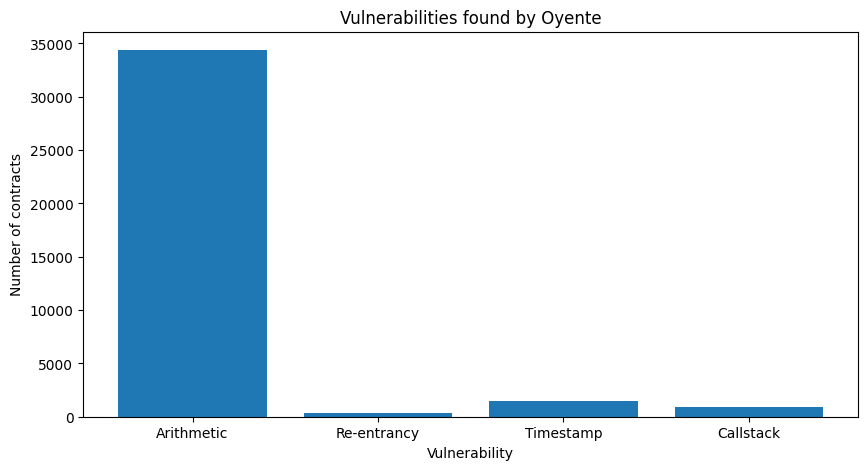

In [61]:
# Print them in a graph

plt.figure(figsize=(10, 5))
plt.bar(['Arithmetic', 'Re-entrancy', 'Timestamp', 'Callstack'], [arithmetic_count, re_entrancy_count, timestamp_count, callstack_count])
plt.title('Vulnerabilities found by Oyente')
plt.xlabel('Vulnerability')
plt.ylabel('Number of contracts')
plt.show()

In [63]:
# Print percentage of the total number of contracts
print('Arithmetic: {:.2f}%'.format(arithmetic_count / len(arithmetic) * 100))
print('Re-entrancy: {:.2f}%'.format(re_entrancy_count / len(re_entrancy) * 100))
print('Timestamp: {:.2f}%'.format(timestamp_count / len(timestamp) * 100))
print('Callstack: {:.2f}%'.format(callstack_count / len(callstack) * 100))

Arithmetic: 72.31%
Re-entrancy: 0.65%
Timestamp: 3.07%
Callstack: 1.86%


In [1]:
# Timestamp also known as Time manipulation
# Callstack also known as Denial of Service

In [22]:
directory_all_contracts = './smartbugs-wild/contracts/'

contracts_folders_names = os.listdir(directory_all_contracts)

total_lines = []

for contract in contracts_folders_names:
  # Check extension
  if contract.endswith('.sol'):
    with open(directory_all_contracts + contract, 'r') as f:
      lines = len(f.readlines())
      total_lines.append(lines)

5625
0
2991
0
27154
0
21717
0
11129
0
26386
0
27156
0
5813
0
461
0
10711
0


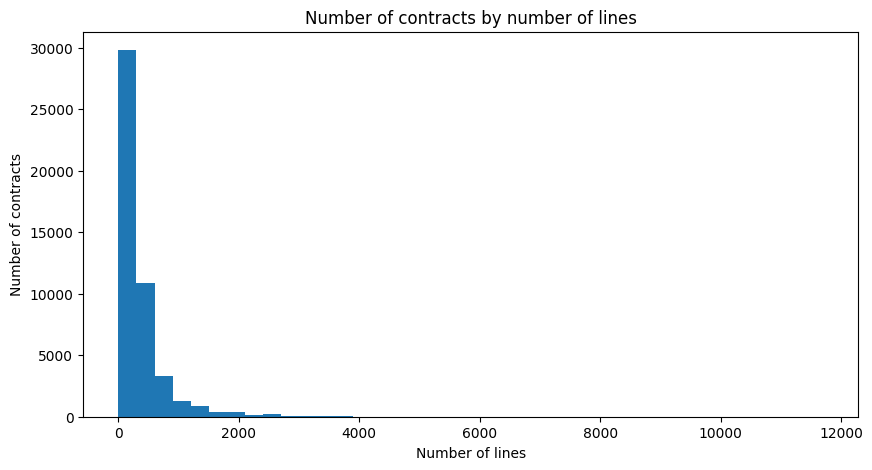

In [17]:
np_total_lines = np.array(total_lines)

max_lines = np_total_lines.max()

# Plot in ranges of 1000 lines

plt.figure(figsize=(10, 5))
plt.hist(np_total_lines, bins=range(0, max_lines, 300))
plt.title('Number of contracts by number of lines')
plt.xlabel('Number of lines')
plt.ylabel('Number of contracts')
plt.show()

In [20]:
print('Average number of lines: {:.2f}'.format(np_total_lines.mean()))
print('Median number of lines: {:.2f}'.format(np.median(np_total_lines)))
print('Standard deviation of number of lines: {:.2f}'.format(np_total_lines.std()))
print('Minimum number of lines: {:.2f}'.format(np_total_lines.min()))
print('Maximum number of lines: {:.2f}'.format(np_total_lines.max()))

Average number of lines: 358.84
Median number of lines: 223.00
Standard deviation of number of lines: 458.75
Minimum number of lines: 1.00
Maximum number of lines: 11706.00
